In [39]:
import pandas as pd
import numpy as np
import glob, os, subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import palettable

In [123]:
def calc_vaf (df, col, location):
    # Split "depthalt" column by comma, convert to integers, and calculate division
    df[['depth', 'alt']] = df[ col ].str.split(',', expand=True).astype(int)
    df['vaf'] = df['alt'] / df['depth']

    #df = df [ df["depth"] >= 10]

    # Drop the intermediate columns if needed
    df = df.drop(['depth', 'alt'], axis=1)
    df [ "location" ] = location
    return df    

def drawfigure_raw (ax, df, row_index, col_index, vaf_col ):
    import scipy.stats as kde
    
    x = np.linspace(0, 0.51, 100)
    kde_function = kde.gaussian_kde( np.array (df [ vaf_col ]) )
    y = kde_function(x) 

    ax.plot (x, y, label = col_index, linewidth = 5, color = '#46A0E7')
    ax.fill_between(x, y, color='#C0E1F7', alpha=0.5)

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )

def drawfigure_common (ax, df, row_index, col_index, vaf_col, weight ):
    import scipy.stats as kde
    
    if df.shape[0] >= 5:
        x = np.linspace(0, 0.51, 100)
        kde_function = kde.gaussian_kde( np.array (df [vaf_col]) )
        y = kde_function(x)  * weight

        ax.plot (x, y, label = col_index, linewidth = 8, color = '#4B4A53')

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )

def drawfigure_clone (ax, df, row_index, col_index, vaf_col, clone_no, weight ):
    import scipy.stats as kde
    import palettable
    
    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
    Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors

    colorlist = [i for i in Pastel_10]

    if df.shape[0] >= 2:
        x = np.linspace(0, 0.51, 100)
        kde_function = kde.gaussian_kde( np.array (df [vaf_col]) )
        y = kde_function(x) * weight

        ax.plot (x, y, label = col_index, linewidth = 3, color = colorlist[clone_no], linestyle='-.')
        ax.fill_between(x, y, color = colorlist[clone_no], alpha=0.4)

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )


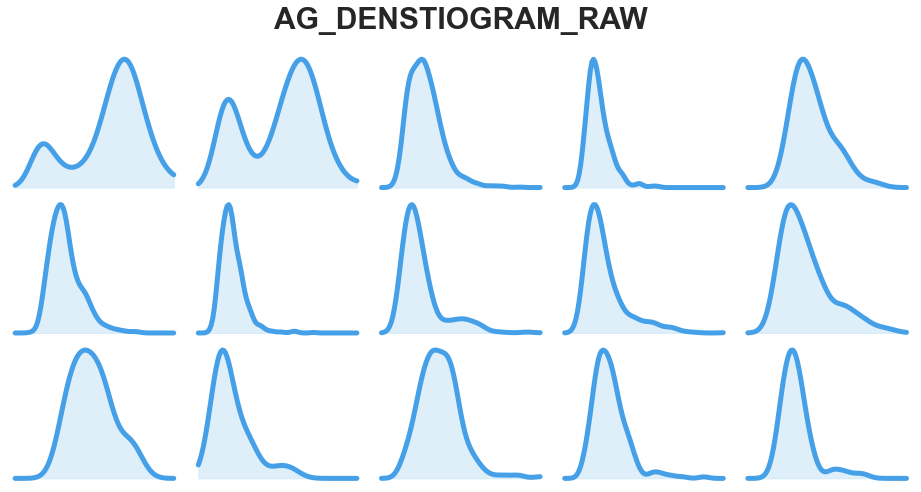

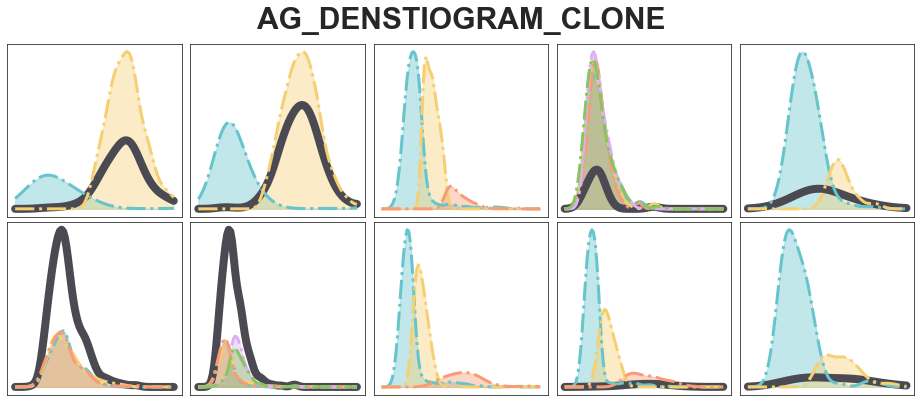

In [124]:
sns.set_style("white")
# #sns.set_palette("tab10")
# sns.set_palette(sns.color_palette(colorlist))


# General_raw
fig_raw, ax_raw = plt.subplots(nrows = 3, ncols = 5, figsize = (14,8))
fig_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.15, top = 0.90, left = 0.05, right = 0.95)
fig_raw.suptitle ( "AG_DENSTIOGRAM_RAW" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

# General_decomposition
fig_clone, ax_clone = plt.subplots(nrows = 2, ncols = 5, figsize = (14, 6.5))
fig_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.15, top = 0.90, left = 0.05, right = 0.95)
fig_clone.suptitle ( "AG_DENSTIOGRAM_CLONE" , fontsize = 30, y = 0.98, fontweight = "semibold")




DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG"
for col_index, location in enumerate( ["L1", "L2", "L3", "L4", "L5"] ) :
    INPUT_TSV_LIST = sorted ( glob.glob ( DIR + "/*{}*".format(location) ) )

    glo_INPUT_TSV = DIR + "/glomerulosa_{}/0.input_containpos.txt".format(location)
    fasc_INPUT_TSV = DIR + "/fasciculata_{}/0.input_containpos.txt".format(location)
    reti_INPUT_TSV = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/3.woMosaic_ver2/PD28690/adrenal_gland_zona/reticularis_{}_input.txt".format(location)

    df_glo = pd.read_csv (glo_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_glo = calc_vaf (df_glo, "depthalt", location)
    df_fasc = pd.read_csv (fasc_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_fasc = calc_vaf (df_fasc, "depthalt", location)
    df_reti = pd.read_csv (reti_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_reti = calc_vaf (df_reti, "depthalt", location)

    df_glofasc = pd.merge ( df_glo,  df_fasc, left_on = "pos", right_on = "pos")
    
    drawfigure_raw ( ax_raw[0][col_index], df_glo, 0, col_index, "vaf" )
    drawfigure_raw ( ax_raw[1][col_index], df_fasc, 1, col_index, "vaf" )
    drawfigure_raw ( ax_raw[2][col_index], df_reti, 2, col_index, "vaf" )
    

    ####################################
    df_glo_membership = pd.read_csv ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/glomerulosa_{}/result/CLEMENT_decision.membership.txt".format(location), header = None, names = ["clone"])
    df_fasc_membership = pd.read_csv ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/fasciculata_{}/result/CLEMENT_decision.membership.txt".format(location), header = None, names = ["clone"])

    df_glo = pd.concat ( [df_glo, df_glo_membership], axis = 1)
    df_fasc = pd.concat ( [df_fasc, df_fasc_membership], axis = 1)


    #  Common 그리기
    weight = df_glofasc.shape[0] / max ( pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[:, 0] )        # 대장 clone의 개수에 비해 common mutation의 개수?
    drawfigure_common (ax_clone[0][col_index], df_glofasc, 0, col_index, "vaf_x", weight)
    weight = df_glofasc.shape[0] / max ( pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[:, 0] )      # 대장 clone의 개수에 비해 common mutation의 개수?
    drawfigure_common (ax_clone[1][col_index], df_glofasc, 1, col_index, "vaf_y", weight)

    # Clone 별로 그리기
    for clone_no in sorted ( set ( df_glo["clone"]) ) :
        weight = pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_clone[0][col_index], df_glo [df_glo["clone"] == clone_no].reset_index(drop = True), 0, col_index, "vaf", clone_no, weight)
    for clone_no in sorted ( set ( df_fasc["clone"]) ) :
        weight = pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_clone[1][col_index], df_fasc [df_fasc["clone"] == clone_no].reset_index(drop = True), 1, col_index, "vaf", clone_no, weight)

fig_raw.show()
fig_clone.show()